# **LDA - 토픽 모델링 클러스터링**

## 라이브러리 및 데이터셋 로드

In [35]:
import pandas as pd
import re
import os
import subprocess


from kiwipiepy import Kiwi
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

import hanja
from hanja import hangul


In [4]:
# df = pd.read_csv("/data/ephemeral/home/yujin/processed_train_4220.csv")
df = pd.read_csv("/data/ephemeral/home/level2-nlp-datacentric-nlp-10/train_denoised_none.csv")
df = df.dropna(subset=['text'])

## 데이터 전처리

In [14]:
# 특수기호 매핑 사전 설정
replacement_dict = {
    'U＋': '유플러스',
    '%': '퍼센트',
    '％': '퍼센트',
    '…': ' ',
    '.': ' ',
    '~': ' ',
    '..': ' ',
    '...': ' ',
    '“': '"',
    '”': '"',
    '’': ' ',
    "'": ' ',
    '·': ' ',
    '↔': ' ',
    '㈜': ' ',
    '→': '에서',
    '↑': '상승',
    '↓': '하락',
    'ｍ': '미터',
    '㎝': '센티미터',
    '㎜': '밀리미터',
    '㎛': '마이크로미터',
    '㎞': '킬로미터',
    '㎡': '제곱미터',
    '＋': '플러스',
    '㎏': '킬로그램',
    '℃': '도',
    '㎓': '기가헤르츠'
}

In [6]:
# 특수기호 제거
def remove_special_char(text):
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
# 특수기호 치환
def replace_special_chars(text):
    for char, replacement in replacement_dict.items():
        text = text.replace(char, replacement)
    return text

In [8]:
# 한자 제거
def remove_hanja(text):
    text = re.sub(r'[\u4E00-\u9FFF]', ' ', text)  # 한자 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
# 한자를 한글로 치환
def convert_hanja_to_korean(text):
    text = hanja.translate(text, 'substitution')
    return text

In [19]:
# 특수기호 치환, 제거, 한자 치환을 수행하는 함수
def preprocess_text(text):
    # [1] 특수기호 치환
    for char, replacement in replacement_dict.items():
        text = text.replace(char, replacement)
    
    # [2] 특수기호 제거 (한글, 영어, 숫자, 공백만 남기기)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # [3] 한자 한글로 치환
    text = hanja.translate(text, 'substitution')
    
    return text

In [20]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df

,ID,text,target,cleaned_text
0,ynat-v1_train_00000,정영석 파파미사일 KT에 이용기간 2년 단축…2분기종료2보,4,정영석 파파미사일 KT에 이용기간 2년 단축 2분기종료2보
1,ynat-v1_train_00001,검찰청에 로또 당첨자 회장에 2억 달러 송금,3,검찰청에 로또 당첨자 회장에 2억 달러 송금
2,ynat-v1_train_00002,北 김정은 자주통일 새 시대 열어나가야 보자,2,김정은 자주통일 새 시대 열어나가야 보자
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩
4,ynat-v1_train_00004,美대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,6,대선 앞두고 중국인 단체 발언서 비공개로 감시 강화
...,...,...,...,...
2795,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6,트럼프 폭스뉴스 앵커들 충성도 점수매겨 10점만점에 12점도
2796,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,2,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠
2797,ynat-v1_train_02797,텔레그램 한인 등 아시아서 2시간 다운…서비스 정상화종료2보,4,텔레그램 한인 등 아시아서 2시간 다운 서비스 정상화종료2보
2798,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1,인터뷰 류현진 친구에게 안타 맞는 것 싫어해 승부는 냉정


## 형태소 분석 및 명사 추출

In [10]:
kiwi = Kiwi()

In [ ]:
data_word = []
def extract_nouns(text):
    tokens = kiwi.tokenize(text)
    nouns = [token.form for token in tokens if token.tag in ['NNG', 'NNB', 'NNP']]
    return nouns

df['nouns'] = df['cleaned_text'].apply(extract_nouns)
df

,ID,text,target,cleaned_text,nouns
0,ynat-v1_train_00000,정영석 파파미사일 KT에 이용기간 2년 단축…2분기종료2보,4,정영석 파파미사일 KT에 이용기간 2년 단축 2분기종료2보,"[정영석, 파파, 미사일, 이용, 기간, 년, 단축, 분기, 종료, 보]"
1,ynat-v1_train_00001,검찰청에 로또 당첨자 회장에 2억 달러 송금,3,검찰청에 로또 당첨자 회장에 2억 달러 송금,"[검찰청, 로또, 당첨자, 회장, 달러, 송금]"
2,ynat-v1_train_00002,北 김정은 자주통일 새 시대 열어나가야 보자,2,김정은 자주통일 새 시대 열어나가야 보자,"[김정은, 자주, 통일, 새, 시대]"
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,"[갤노트8, 주말, 대, 개통, 시장, 불법, 보조금, 얼룩]"
4,ynat-v1_train_00004,美대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,6,대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,"[대선, 중국인, 단체, 발언, 서, 공개, 감시, 강화]"
...,...,...,...,...,...
2795,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6,트럼프 폭스뉴스 앵커들 충성도 점수매겨 10점만점에 12점도,"[트럼프, 폭스뉴스, 앵커, 충성도, 점수, 점, 만점, 점]"
2796,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,2,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,"[삼성, 갤럭시S, 정식, 출시, 주말, 이통, 시장]"
2797,ynat-v1_train_02797,텔레그램 한인 등 아시아서 2시간 다운…서비스 정상화종료2보,4,텔레그램 한인 등 아시아서 2시간 다운 서비스 정상화종료2보,"[텔레그램, 한인, 등, 아시아, 시간, 서비스, 정상, 종료, 보]"
2798,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1,인터뷰 류현진 친구에게 안타 맞는 것 싫어해 승부는 냉정,"[인터뷰, 류현진, 친구, 안타, 것, 승부, 냉정]"


## gensim용 객체(dictionary, corpus) 생성

In [39]:
texts = df['nouns'].tolist()

# Gensim Dictionary 생성
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Corpus 생성
corpus = [dictionary.doc2bow(text) for text in texts]

In [57]:
# Gensim LDA 학습
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=7,         # 원하는 토픽 개수
    random_state=42,
    passes=15,            # 반복 횟수 조정 가능
    chunksize=100,        # 처리할 문서 크기 조정 가능
    alpha='auto',         # 토픽별 가중치 최적화를 위한 매개변수
    eta='auto'            # 단어별 가중치 최적화를 위한 매개변수
)

# 학습된 모델 결과 확인
for idx, topic in ldamodel.show_topics(formatted=False):
    # 단어의 글자수가 2개 이상인 단어만 필터링
    filtered_topic = [word for word, _ in topic if len(word) > 1]
    print(f"Topic {idx + 1}: {filtered_topic}")

Topic 1: ['정상', '발표', '이란', '기술', '여행', '회담']
Topic 2: ['프로', '농구', '서비스', '선수', '한국', '개발']
Topic 3: ['출시', '아이폰', '시장', '시간', '총리', '민주', '종료']
Topic 4: ['대표', '류현진', '투자', '전국', '정부', '규모']
Topic 5: ['삼성', '리그', '국내', '스마트폰', '전자', '공개', '중단']
Topic 6: ['종합', '퍼센트', '지원', '상승', '게시판', '분기', '중국', '증가', '미국']
Topic 7: ['대통령', '트럼프', '시즌', '충북']


## 최적의 토픽 수 탐색

In [41]:
# 최적 토픽 수 계산 함수
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [42]:
# 최적의 토픽 모델 선정
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=4, limit=11, step=2)
x = range(4, 11, 2)
optimal_model_idx = max(enumerate(coherence_values), key=lambda x: x[1])[0]
optimal_model = model_list[optimal_model_idx]

In [44]:
df

,ID,text,target,cleaned_text,nouns
0,ynat-v1_train_00000,정영석 파파미사일 KT에 이용기간 2년 단축…2분기종료2보,4,정영석 파파미사일 KT에 이용기간 2년 단축 2분기종료2보,"[정영석, 파파, 미사일, 이용, 기간, 년, 단축, 분기, 종료, 보]"
1,ynat-v1_train_00001,검찰청에 로또 당첨자 회장에 2억 달러 송금,3,검찰청에 로또 당첨자 회장에 2억 달러 송금,"[검찰청, 로또, 당첨자, 회장, 달러, 송금]"
2,ynat-v1_train_00002,北 김정은 자주통일 새 시대 열어나가야 보자,2,김정은 자주통일 새 시대 열어나가야 보자,"[김정은, 자주, 통일, 새, 시대]"
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,"[갤노트8, 주말, 대, 개통, 시장, 불법, 보조금, 얼룩]"
4,ynat-v1_train_00004,美대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,6,대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,"[대선, 중국인, 단체, 발언, 서, 공개, 감시, 강화]"
...,...,...,...,...,...
2795,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6,트럼프 폭스뉴스 앵커들 충성도 점수매겨 10점만점에 12점도,"[트럼프, 폭스뉴스, 앵커, 충성도, 점수, 점, 만점, 점]"
2796,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,2,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,"[삼성, 갤럭시S, 정식, 출시, 주말, 이통, 시장]"
2797,ynat-v1_train_02797,텔레그램 한인 등 아시아서 2시간 다운…서비스 정상화종료2보,4,텔레그램 한인 등 아시아서 2시간 다운 서비스 정상화종료2보,"[텔레그램, 한인, 등, 아시아, 시간, 서비스, 정상, 종료, 보]"
2798,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1,인터뷰 류현진 친구에게 안타 맞는 것 싫어해 승부는 냉정,"[인터뷰, 류현진, 친구, 안타, 것, 승부, 냉정]"


In [46]:
# 각 문서에 대해 주요 토픽 분석
def format_topics_sentences(ldamodel, corpus, texts, original_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # 주요 토픽만 추가
                wp = ldamodel.show_topic(topic_num, topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                # DataFrame에 행 추가
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
                # sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df = pd.concat([sent_topics_df.reset_index(drop=True), original_data.reset_index(drop=True)], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts, original_data=df[['ID', 'text', 'target', 'cleaned_text', 'nouns']])

In [51]:
# 컬럼 이름 재정의 및 각 문서의 주요 토픽 출력
df_topic_news = df_topic_sents_keywords.reset_index()
df_topic_news.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'ID', 'text', 'target', 'cleaned_text', 'nouns']
df_topic_news.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,ID,text,target,cleaned_text,nouns
0,0,6,0.4057,"대통령, 년, 전, 차, 것, 만, 리그, 문, 개최, 필요",ynat-v1_train_00000,정영석 파파미사일 KT에 이용기간 2년 단축…2분기종료2보,4,정영석 파파미사일 KT에 이용기간 2년 단축 2분기종료2보,"[정영석, 파파, 미사일, 이용, 기간, 년, 단축, 분기, 종료, 보]"
1,1,0,0.1250,"대, 년, 이란, 세계, 전국, 정부, 기술, 계약, 시작, 발표",ynat-v1_train_00001,검찰청에 로또 당첨자 회장에 2억 달러 송금,3,검찰청에 로또 당첨자 회장에 2억 달러 송금,"[검찰청, 로또, 당첨자, 회장, 달러, 송금]"
2,2,0,0.1250,"대, 년, 이란, 세계, 전국, 정부, 기술, 계약, 시작, 발표",ynat-v1_train_00002,北 김정은 자주통일 새 시대 열어나가야 보자,2,김정은 자주통일 새 시대 열어나가야 보자,"[김정은, 자주, 통일, 새, 시대]"
3,3,0,0.3750,"대, 년, 이란, 세계, 전국, 정부, 기술, 계약, 시작, 발표",ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,"[갤노트8, 주말, 대, 개통, 시장, 불법, 보조금, 얼룩]"
4,4,5,0.5313,"서, 중, 게시판, 중국, 서울, 미국, 삼성, 핵, 강화, 조사",ynat-v1_train_00004,美대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,6,대선 앞두고 중국인 단체 발언서 비공개로 감시 강화,"[대선, 중국인, 단체, 발언, 서, 공개, 감시, 강화]"


In [52]:
# 토픽별 상위 문서 그룹화
sent_topics_sorteddf = pd.DataFrame()
for i, grp in df_topic_sents_keywords.groupby('Dominant_Topic'):
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)
sent_topics_sorteddf.reset_index(drop=True, inplace=True)


In [53]:
# 토픽 비율 요약
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)
topic_contribution = round(topic_counts / topic_counts.sum(), 4)

In [55]:
# 결과 요약 데이터프레임
lda_inform = pd.concat([sent_topics_sorteddf, topic_counts, topic_contribution], axis=1)
lda_inform.columns = ["Topic_Num", "Topic_Perc_Contrib", "Keywords", "ID", "text", "target", "cleaned_text", "nouns", "Num_Documents", "Perc_Documents"]
lda_inform = lda_inform[["Topic_Num", "Keywords", "Num_Documents", "Perc_Documents"]]
lda_inform.head()

,Topic_Num,Keywords,Num_Documents,Perc_Documents
0,0,"대, 년, 이란, 세계, 전국, 정부, 기술, 계약, 시작, 발표",820,0.3020
1,1,"명, 프로, 개발, 투자, 출시, 시즌, 선수, 농구, 여행, 교육",299,0.1101
2,2,"종합, 일, 보, 정상, 보도, 회담, 시간, 중단, 도, 만",294,0.1083
3,3,"위, 대표, 시장, 팀, 아이폰, 폰, 류현진, 국내, 서비스, 공개",262,0.0965
4,4,"원, 한국, 등, 경기, 주, 개, 감독, 경제, 가능, 민주",259,0.0954


In [56]:
# 토픽 번호 조정 (1부터 시작)
lda_inform['Topic_Num'] = lda_inform['Topic_Num'] + 1
df_topic_news['Dominant_Topic'] = df_topic_news['Dominant_Topic'] + 1

# 최종 결과 확인
print(lda_inform)
print(df_topic_news)

   Topic_Num                                Keywords  Num_Documents  \
0          1    대, 년, 이란, 세계, 전국, 정부, 기술, 계약, 시작, 발표            820   
1          2   명, 프로, 개발, 투자, 출시, 시즌, 선수, 농구, 여행, 교육            299   
2          3      종합, 일, 보, 정상, 보도, 회담, 시간, 중단, 도, 만            294   
3          4  위, 대표, 시장, 팀, 아이폰, 폰, 류현진, 국내, 서비스, 공개            262   
4          5      원, 한국, 등, 경기, 주, 개, 감독, 경제, 가능, 민주            259   
5          6    서, 중, 게시판, 중국, 서울, 미국, 삼성, 핵, 강화, 조사            237   
6          7       대통령, 년, 전, 차, 것, 만, 리그, 문, 개최, 필요            265   
7          8   퍼센트, 월, 상승, 시, 분기, 증가, 지원, 하락, 추진, 총리            279   

   Perc_Documents  
0          0.3020  
1          0.1101  
2          0.1083  
3          0.0965  
4          0.0954  
5          0.0873  
6          0.0976  
7          0.1028  
      Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0               7              0.4057   
1               1               1              0.1250   
2        

## 토픽 모델링 결과 시각화 (WordCloud)

In [58]:
# 토픽별 Word Cloud 생성
def flatten(l):
    flatList = []
    for elem in l:
        if isinstance(elem, list):
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

In [ ]:
topic_num = 7
for i in range(1, tupleopic_num + 1):
    data_list = globals()['df_{}'.format(i)].Text.values.tolist()
    data_word = []
    
    for j in range(len(data_list)):
        data_word.append(extract_nouns(data_list[j]))
    
    data_word = flatten(data_word)
    data_word = [x for x in data_word if not x.isdigit()]  # 숫자 제거
    
    freq = pd.Series(data_word).value_counts().head(50)
    freq = dict(freq)
    
    # Word Cloud 생성
    wordcloud = WordCloud(font_path="./Font/BMHANNA_11yrs_ttf.ttf",
                          relative_scaling=0.2,
                          background_color='white').generate_from_frequencies(freq)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

KeyError: 'df_1'

In [32]:
# 한글 폰트 경로 지정 (예: 나눔고딕)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 경로는 시스템 환경에 따라 다를 수 있습니다.

# WordCloud 생성 함수
def plot_wordcloud(topic_words, topic_num):
    wordcloud = WordCloud(
        font_path=font_path,         # 한글 폰트 설정
        background_color='white',
        max_words=30,
        width=800,
        height=400
    ).generate_from_frequencies(dict(topic_words))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num}')
    plt.show()

# 토픽별로 WordCloud 시각화
for idx, topic in enumerate(optimal_model.show_topics(formatted=False)):
    plot_wordcloud(topic[1], idx+1)

OSError: cannot open resource

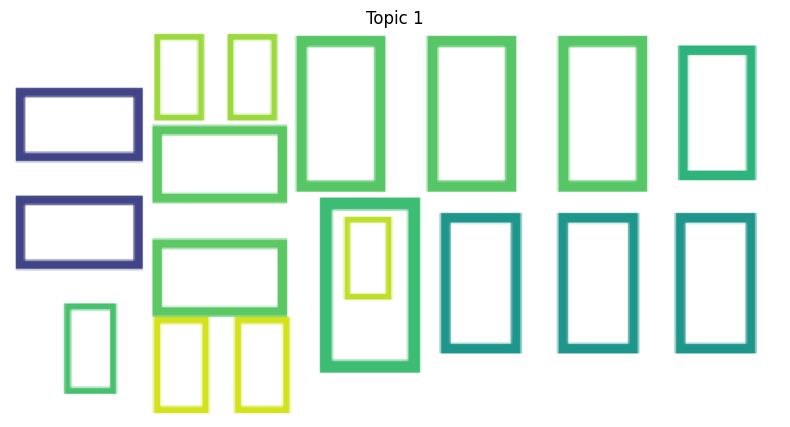

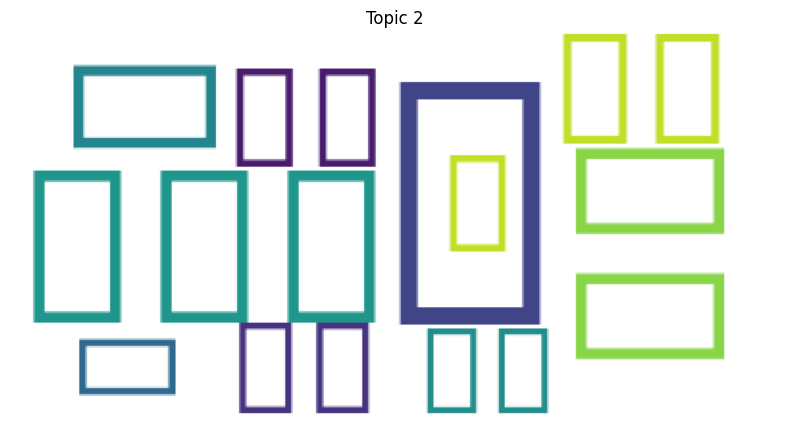

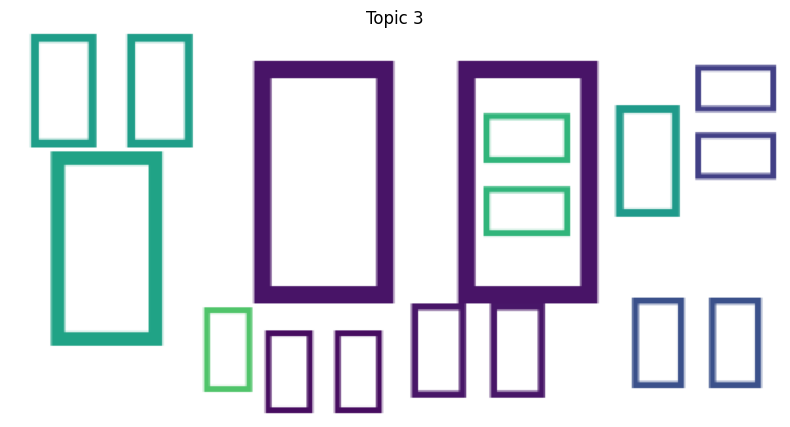

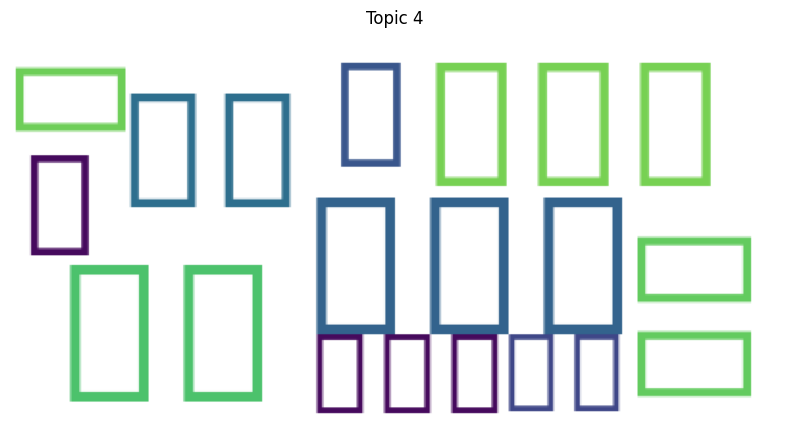

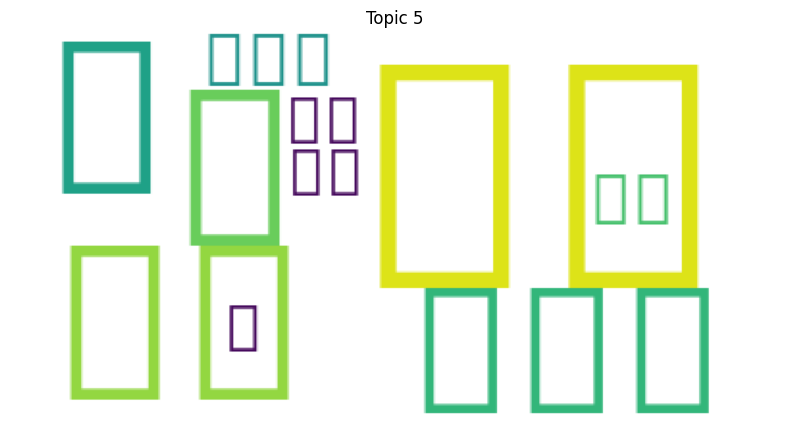

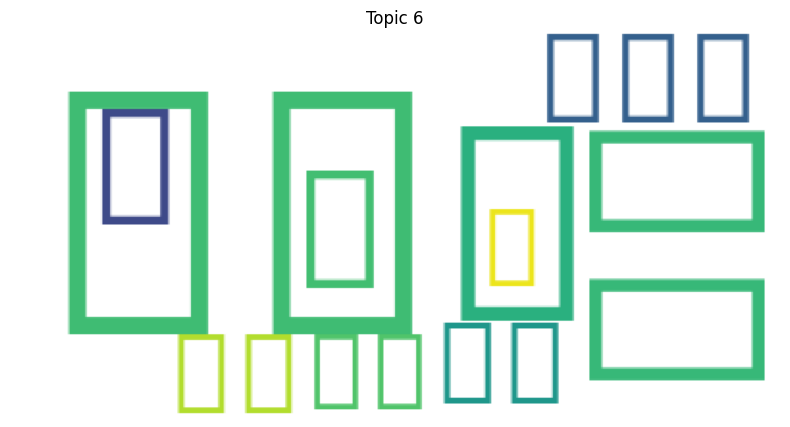

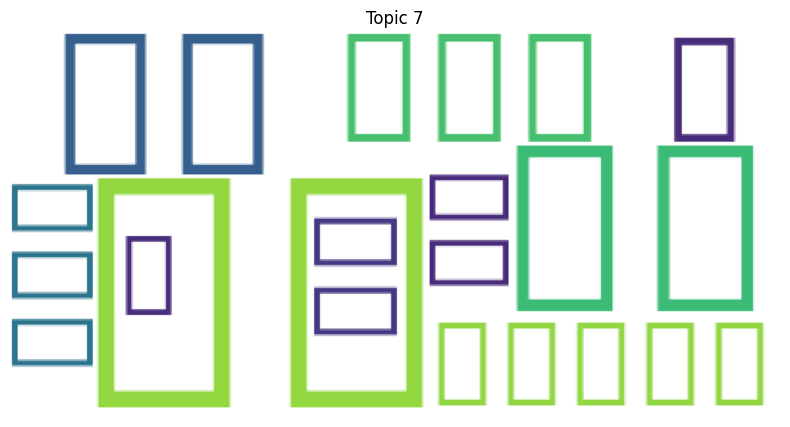

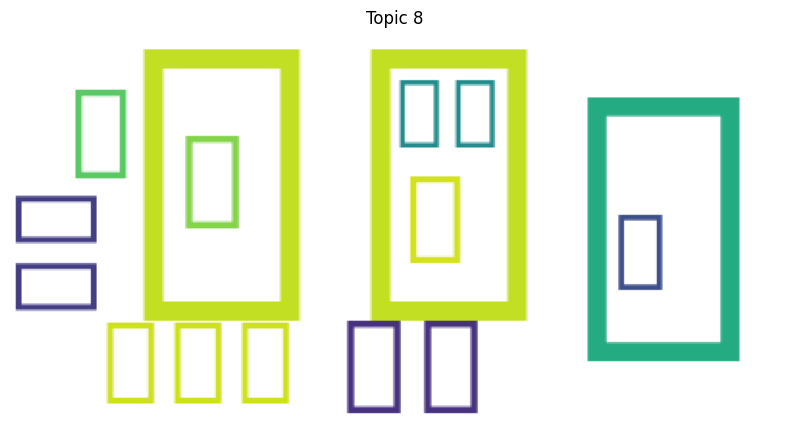

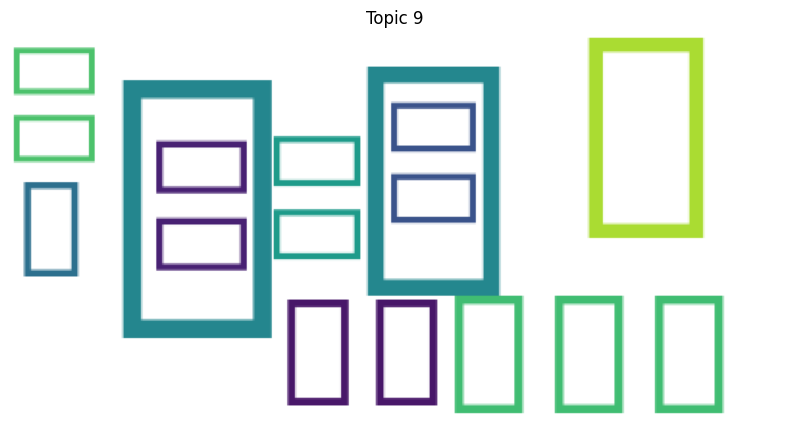

In [30]:
for idx, topic in enumerate(optimal_model.show_topics(formatted=False)):
    plt.figure(figsize=(10, 5))
    plt.imshow(WordCloud(background_color='white', max_words=30).fit_words(dict(topic[1])))
    plt.axis('off')
    plt.title(f'Topic {idx+1}')
    plt.show()

## LDAvis 시각화

In [62]:
import numpy as np

def lda(optimal_model):
    model_gensim = LdaModel(
        id2word=optimal_model.id2word, num_topics=optimal_model.num_topics,
        alpha=optimal_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = optimal_model.state.sstats
    return model_gensim
model = lda(optimal_model)

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.202400 -0.085524       1        1  15.143650
7      0.075928  0.258632       2        1  14.086207
5     -0.003826 -0.130720       3        1  13.253092
6      0.262511 -0.117342       4        1  12.630957
4     -0.086560  0.324179       5        1  12.378165
2      0.021823  0.012117       6        1  11.045513
0      0.243875 -0.108454       7        1  11.025685
3     -0.311351 -0.152888       8        1  10.436732, topic_info=    Term        Freq       Total Category  logprob  loglift
16    종합  216.000000  216.000000  Default  30.0000  30.0000
23   퍼센트  106.000000  106.000000  Default  29.0000  29.0000
38     일   95.000000   95.000000  Default  28.0000  28.0000
9      명  108.000000  108.000000  Default  27.0000  27.0000
15   대통령   97.000000   97.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
91    세계    0.042669   42.030131   Topic8  -9.3149  -4.6328
102   시간    0.012174   20.092538   Topic8 -10.5691  -5.1490
31    서울    0.025806   50.861917   Topic8  -9.8178  -5.3264
48     종    0.004074   24.341029   Topic8 -11.6637  -6.4354
8      서    0.009827   92.922582   Topic8 -10.7832  -6.8945

[286 rows x 6 columns], token_table=      Topic      Freq Term
term                      
33        5  0.996261   가능
35        1  0.029980   감독
35        5  0.989349   감독
6         3  0.992863   강화
43        5  0.986507    개
...     ...       ...  ...
98        4  0.044796   회담
98        6  0.940715   회담
92        1  0.584777    후
92        2  0.155941    후
92        4  0.272896    후

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 6, 7, 5, 3, 1, 4])